In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# ignore warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

### DO NOTE

We are only plotting for Seasonals since data cleaning for seasons dropped all non-seasonals

In [42]:
# set categorical types
category_cols = ['Rating','Type','Status','Source','season']
int_cols = ['Rank','Episodes','Scored By','Popularity','Favorites','Members','Premier_Month']
float_cols = ['Score']

genres = ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi']

types = dict([(i,'category') for i in category_cols])

df = pd.read_csv('cleaned_data.csv')
df = df.astype(types)

### Split the df

In [43]:
# calculate number of datapoints for train set
def split_dataset(df:object, train_set_ratio:float):
    """splits a dataset, with the size of train_set being determined by train_set_ratio
    @param df: The dataframe to split
    @param train_set_ratio: Float between 0 and 1 to determine the ratio of the df to be the train_set
    @returns train_set: The train set
    @returns test_set: The test set"""

    # shuffle the data so we don't just take the first 20% as test set.
    df = df.sample(frac=1).reset_index(drop=True)

    # calculate the splits
    entry_count = len(df.index)
    train_count = (int)(entry_count*train_set_ratio)

    # split
    train_set = df[:train_count]
    test_set = df[train_count:]

    print(f'total: {entry_count}\ntrain: {train_set.shape}\ntest: {test_set.shape}')
    return train_set, test_set

train_set, test_set = split_dataset(df,0.8)

total: 4281
train: (3424, 45)
test: (857, 45)


### Plotting the numerical data

For Premier Month: Months since 1900 that the show premiered in

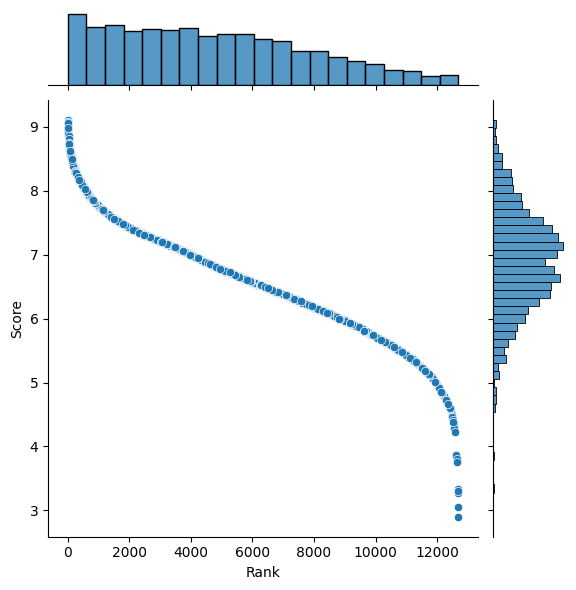

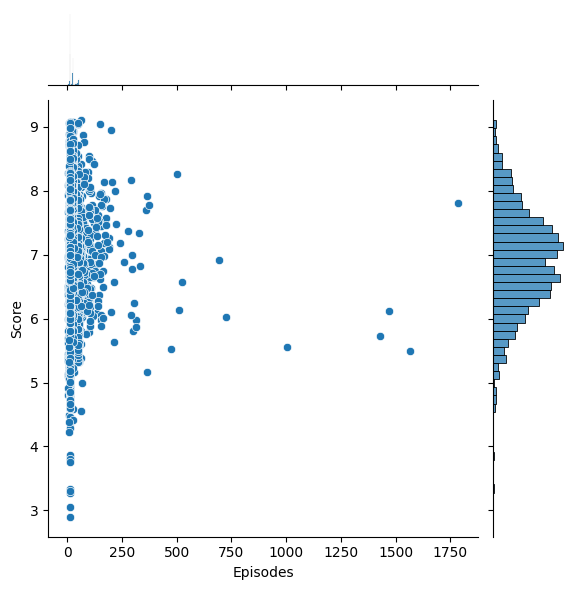

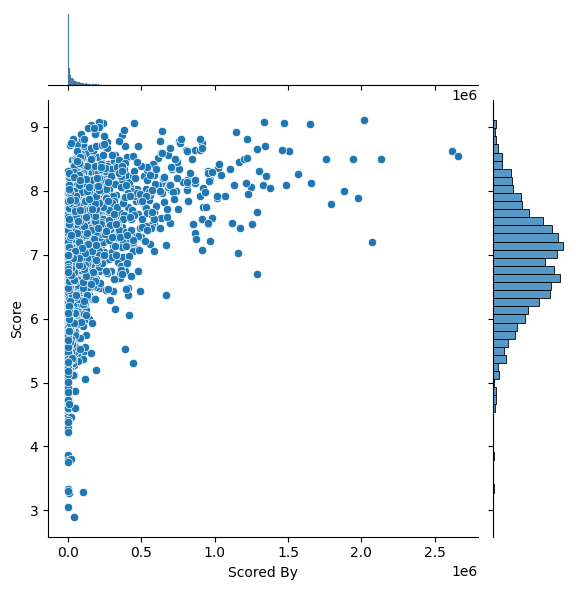

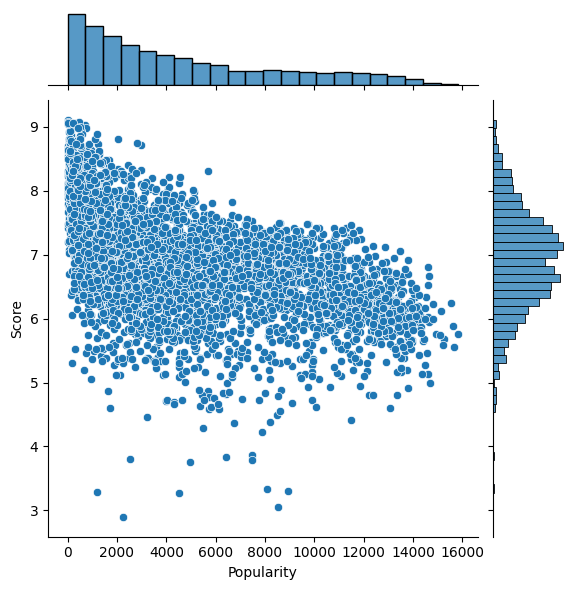

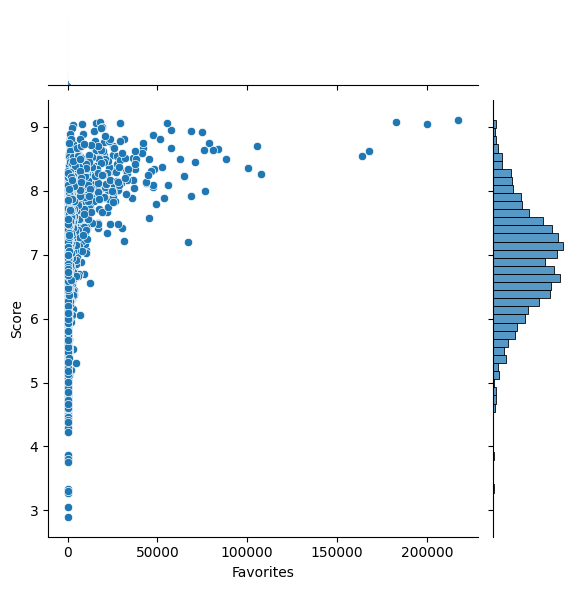

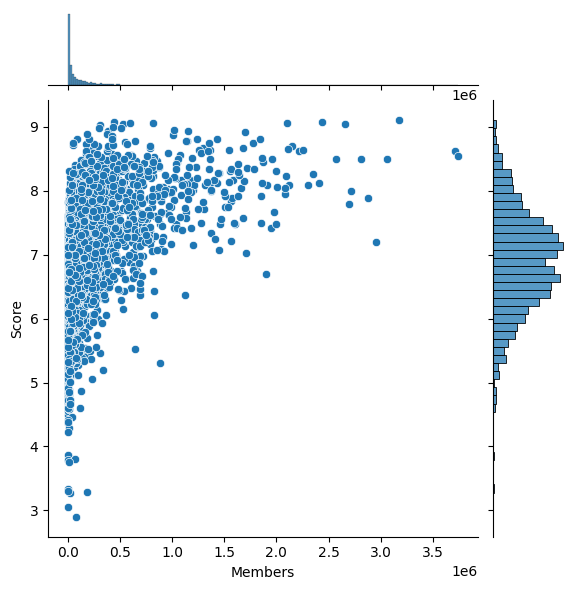

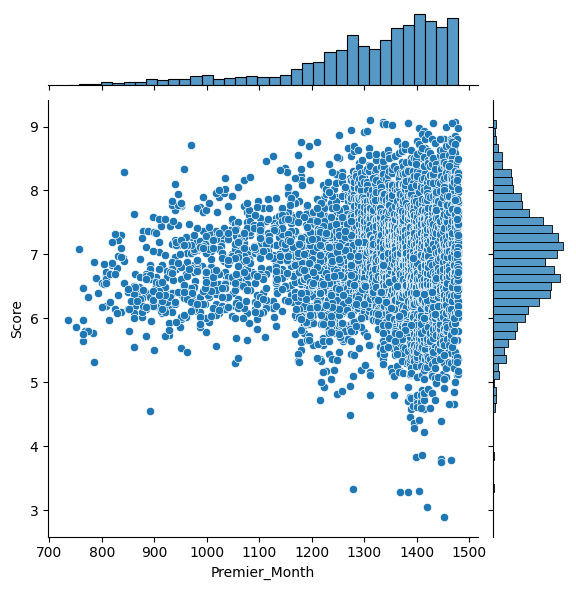

In [44]:
for y in int_cols:
    sb.jointplot(x=df[y],y=df['Score'])

### Linear Regression code yanked from Exercise 4

In [53]:
def prediction_plot(x:str, train_set:pd.DataFrame, test_set:pd.DataFrame, results:dict):
    """just a helper function to plot predictions against actuals"""
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(train_set[[x]], results['train'], color = "blue")
    axes[0].plot(train_set[[x]], train_set[[x]], linewidth = 1, color = 'black')
    axes[0].set_xlabel(f"True values of {x}")
    axes[0].set_ylabel(f"Predicted values of {x}")
    axes[1].scatter(test_set[[x]], results['test'], color = "green")
    axes[1].plot(test_set[[x]], test_set[[x]], linewidth = 1, color='black')
    axes[1].set_xlabel(f"True values of {x}")
    axes[1].set_ylabel(f"Predicted values of {x}")
    plt.show()

def linear_regression(x:str, y:str, train_set:pd.DataFrame, test_set:pd.DataFrame):
    """does linear regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    linreg = LinearRegression()
    # check if list
    if type(y) is list:
        linreg.fit(train_set[y],train_set[[x]])
    else:
        linreg.fit(train_set[[y]],train_set[[x]])

    # print the intercept & coef in the form y = m*x + c
    print(f"""Line Equation
        {x} = {linreg.coef_}*{y} + {linreg.intercept_}
        """)

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = linreg.predict(datay)
        
        r2 = linreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

### Performing Linear Regression

For Premier Month: Months passed since 1900 

=============== Rank ===============
Line Equation
        Score = [[-0.00024756]]*Rank + [8.06196484]
        
train dataset
        R^2: 0.9543420001919234
        MSE: 0.029346451072544185
        
test dataset
        R^2: 0.9600784822439261
        MSE: 0.025516515251173287
        


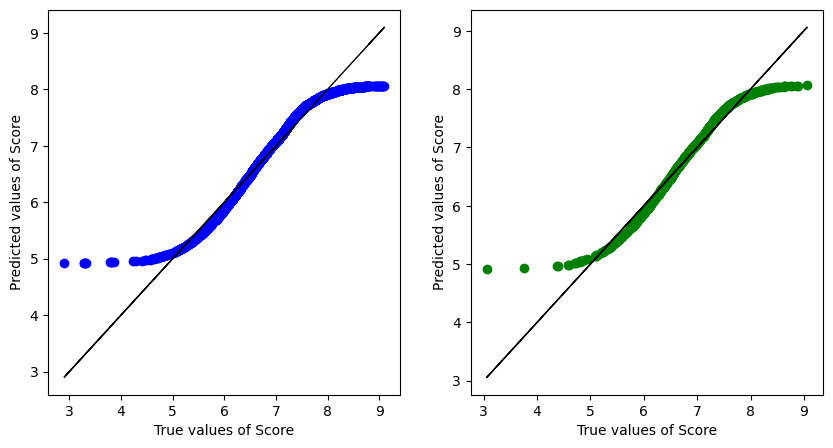

=============== Episodes ===============
Line Equation
        Score = [[-5.51562717e-05]]*Episodes + [6.88872989]
        
train dataset
        R^2: 1.7648010904647293e-05
        MSE: 0.6427336565204624
        
test dataset
        R^2: -0.00029266350548717845
        MSE: 0.6393540235601678
        


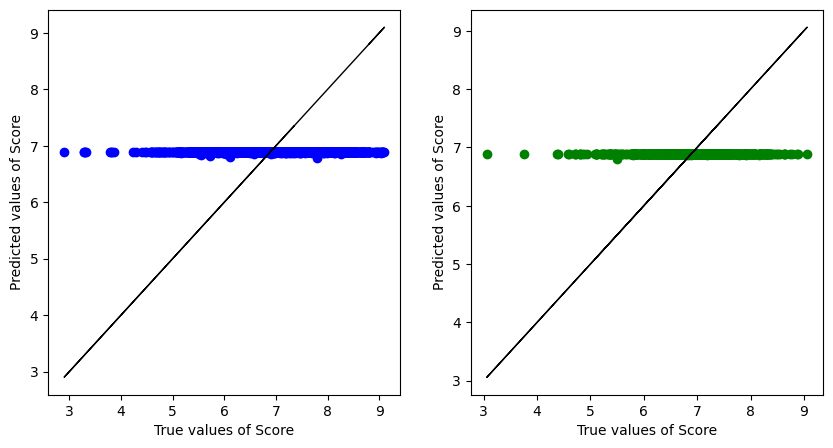

=============== Scored By ===============
Line Equation
        Score = [[1.61517789e-06]]*Scored By + [6.75005064]
        
train dataset
        R^2: 0.17445682095909754
        MSE: 0.5306137503577384
        
test dataset
        R^2: 0.15683775566392733
        MSE: 0.5389214507893191
        


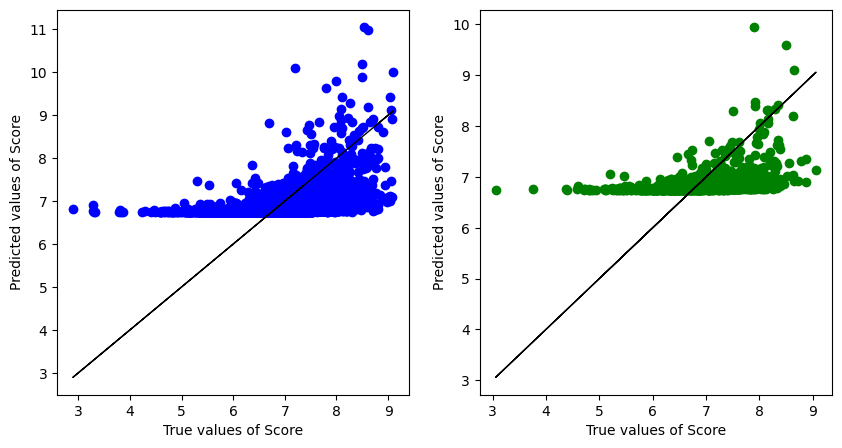

=============== Popularity ===============
Line Equation
        Score = [[-0.0001105]]*Popularity + [7.39984255]
        
train dataset
        R^2: 0.29728737690391605
        MSE: 0.451665024714913
        
test dataset
        R^2: 0.2699877999178526
        MSE: 0.4665996806723263
        


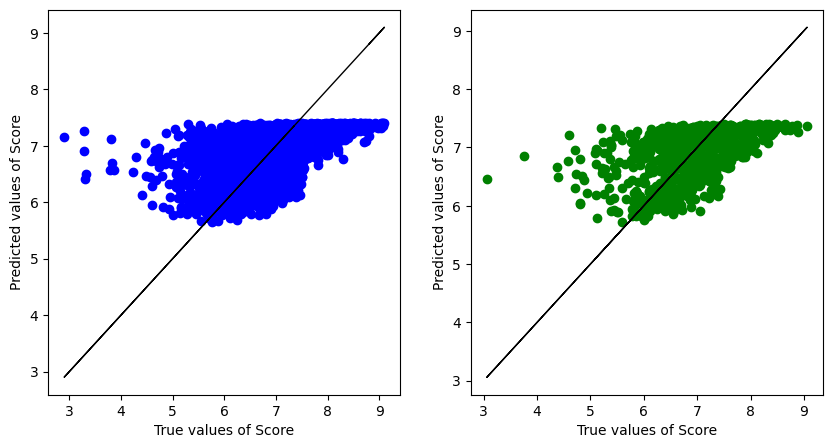

=============== Favorites ===============
Line Equation
        Score = [[2.7527886e-05]]*Favorites + [6.82486349]
        
train dataset
        R^2: 0.12230003288809332
        MSE: 0.5641372650903315
        
test dataset
        R^2: 0.10718450102606625
        MSE: 0.5706581707451781
        


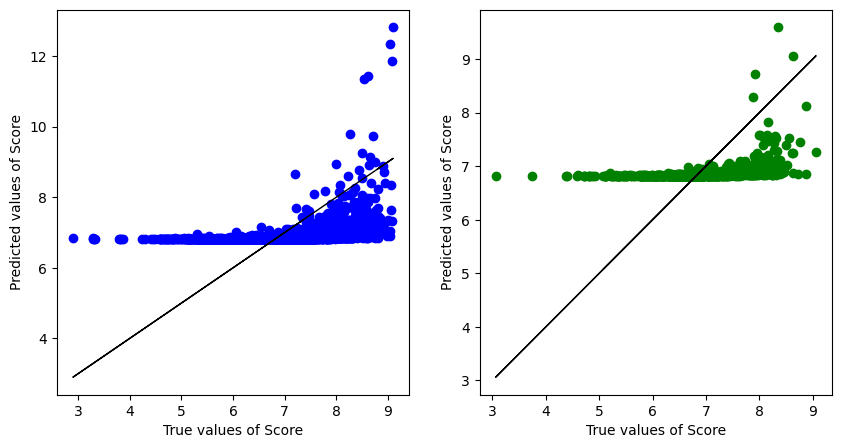

=============== Members ===============
Line Equation
        Score = [[1.08846562e-06]]*Members + [6.70870905]
        
train dataset
        R^2: 0.21130741394131447
        MSE: 0.5069282159827619
        
test dataset
        R^2: 0.19174826969511005
        MSE: 0.5166078035691444
        


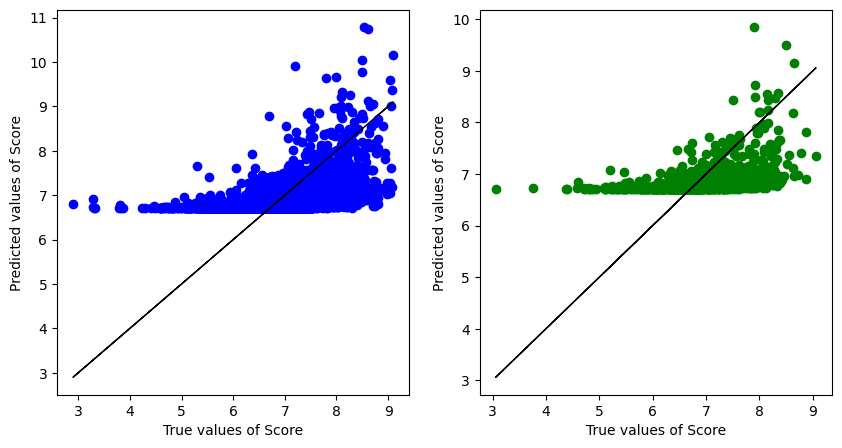

=============== Premier_Month ===============
Line Equation
        Score = [[0.00033362]]*Premier_Month + [6.45296047]
        
train dataset
        R^2: 0.003853860460936054
        MSE: 0.6402679501504515
        
test dataset
        R^2: 8.013712444954191e-05
        MSE: 0.6391157417138323
        


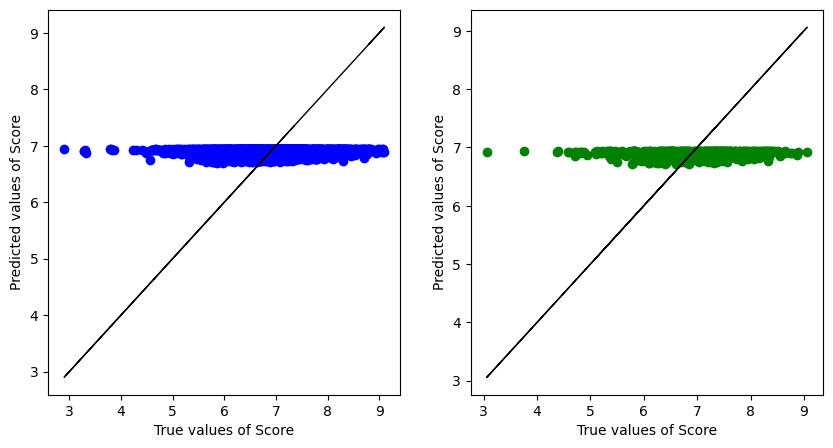

Rank regression
0 dataset
        R^2: 0.9543420001919234
        MSE: 0.029346451072544185
        
1 dataset
        R^2: 0.9600784822439261
        MSE: 0.025516515251173287
        
Episodes regression
0 dataset
        R^2: 1.7648010904647293e-05
        MSE: 0.6427336565204624
        
1 dataset
        R^2: -0.00029266350548717845
        MSE: 0.6393540235601678
        
Scored By regression
0 dataset
        R^2: 0.17445682095909754
        MSE: 0.5306137503577384
        
1 dataset
        R^2: 0.15683775566392733
        MSE: 0.5389214507893191
        
Popularity regression
0 dataset
        R^2: 0.29728737690391605
        MSE: 0.451665024714913
        
1 dataset
        R^2: 0.2699877999178526
        MSE: 0.4665996806723263
        
Favorites regression
0 dataset
        R^2: 0.12230003288809332
        MSE: 0.5641372650903315
        
1 dataset
        R^2: 0.10718450102606625
        MSE: 0.5706581707451781
        
Members regression
0 dataset
        R^2: 0.211307413

In [46]:
regs = dict([(y , {}) for y in int_cols])
for y in int_cols:
    regs[y]['r2'], regs[y]['mse'] = linear_regression('Score',y,train_set=train_set, test_set=test_set)

for name, res in regs.items():
    print(f"{name} regression")
    for i in range(len(res['r2'])):
        print(f"""{i} dataset
        R^2: {res['r2'][i]}
        MSE: {res['mse'][i]}
        """)


### Categorical Data

For seasons:

    0: Winter
    1: Spring
    2: Summer
    3: Autumn

In [47]:
def plot_categories(x,y):
    """plot the boxplot of x against y, as well as the countplot of y.
    @param x: The variable to be investigated
    @param y: The categorical data"""
    print(f'=============== {y} ===============')
    df2 = df[[y, x]].astype({y:'category'}) # need to set variable as category
    cats = df2[y].cat.categories
    plt.figure(figsize=(8,4))
    sb.countplot(data=df2[y])
    plt.show()
    print(f'categories: {len(cats)}')

    plt.figure(figsize=(8,4))
    sb.boxplot(data=df2, x=x,y=y,orient='h')
    plt.show()

=============== Rating ===============


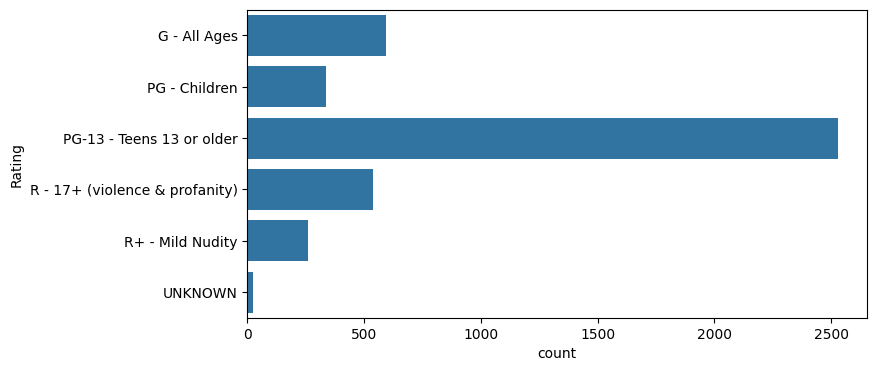

categories: 6


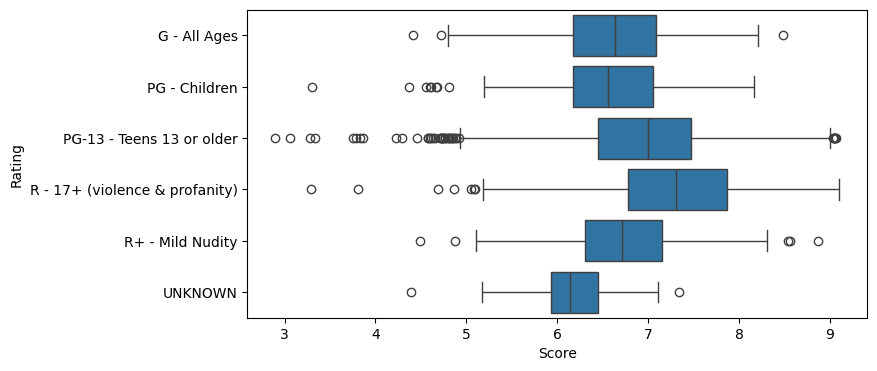

=============== Type ===============


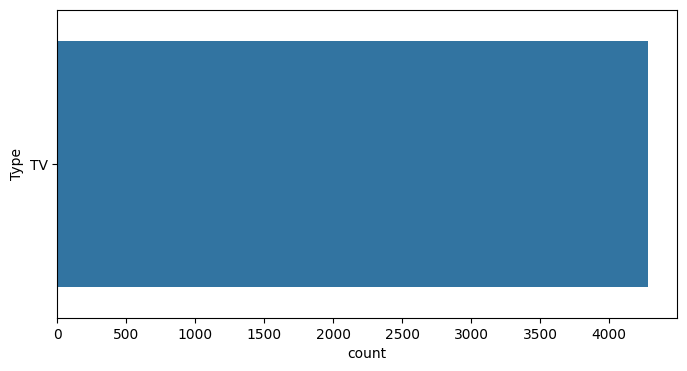

categories: 1


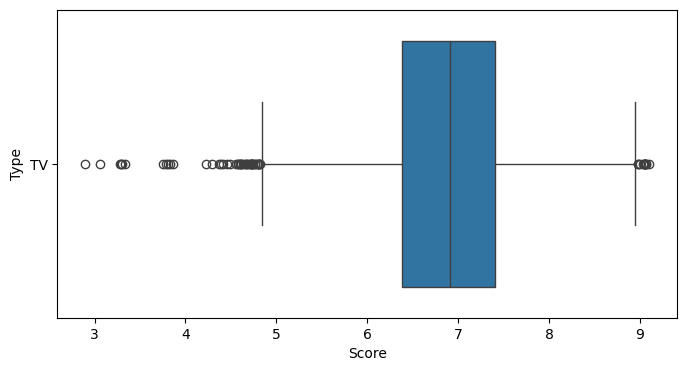

=============== Status ===============


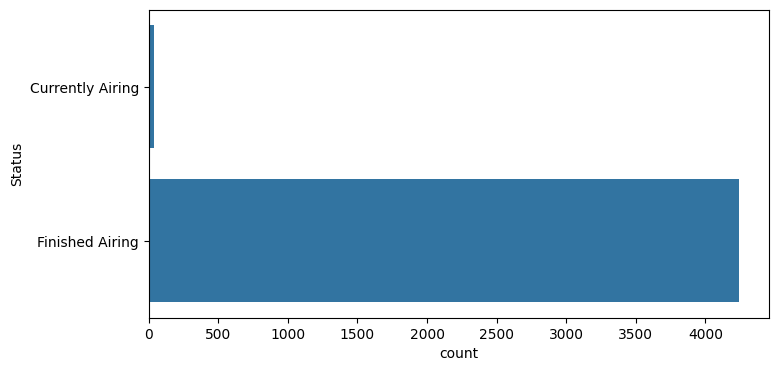

categories: 2


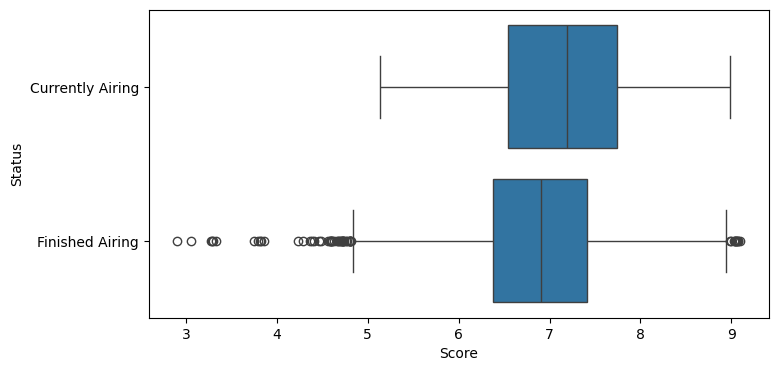

=============== Source ===============


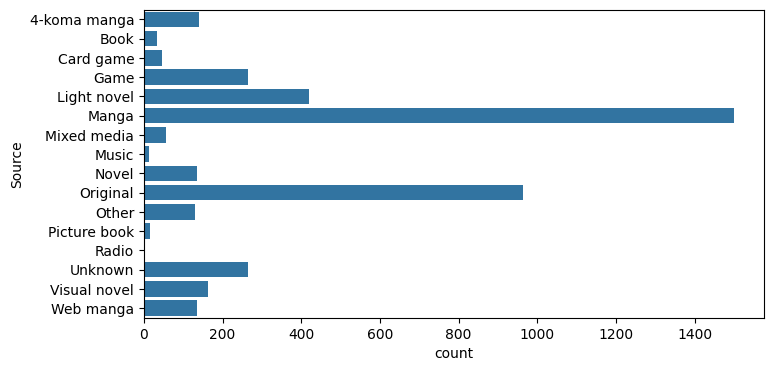

categories: 16


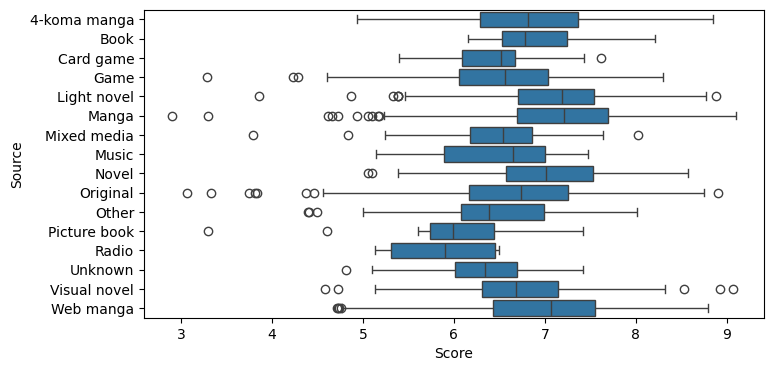

=============== season ===============


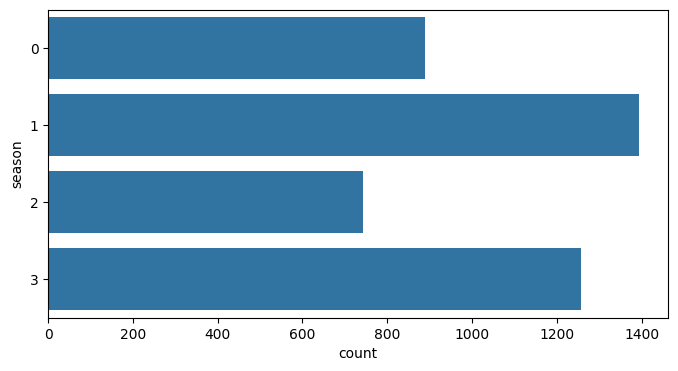

categories: 4


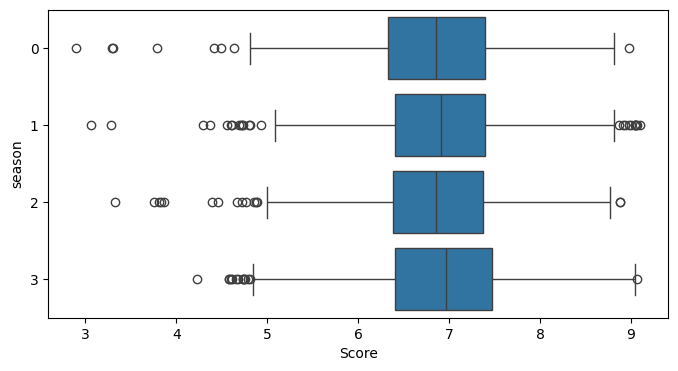

In [48]:
for y in category_cols:
    plot_categories('Score',y)

=================Action=================
Count: 1458


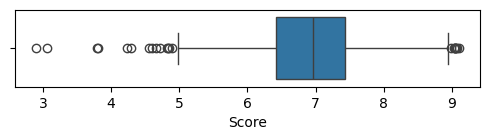

=================Adventure=================
Count: 995


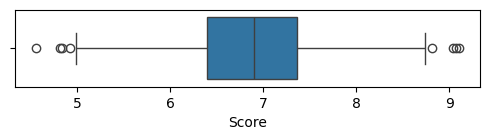

=================Avant Garde=================
Count: 18


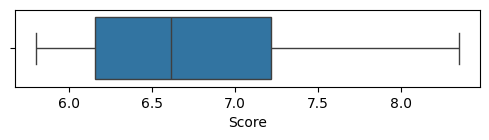

=================Award Winning=================
Count: 54


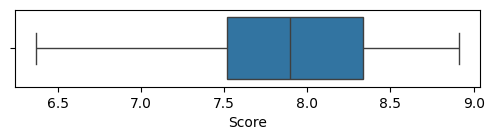

=================Boys Love=================
Count: 30


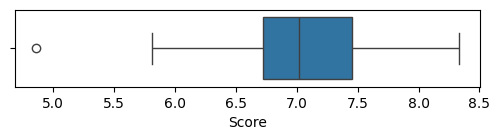

=================Comedy=================
Count: 1826


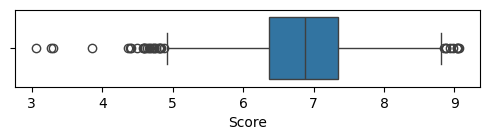

=================Drama=================
Count: 830


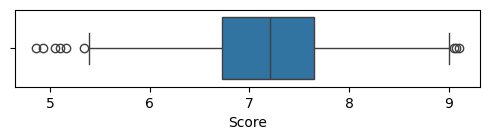

=================Fantasy=================
Count: 1091


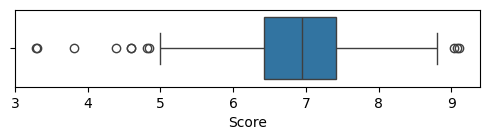

=================Girls Love=================
Count: 43


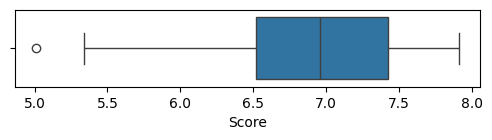

=================Gourmet=================
Count: 57


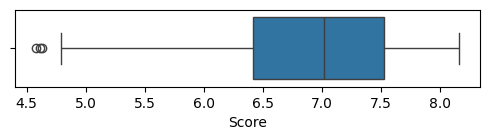

=================Horror=================
Count: 135


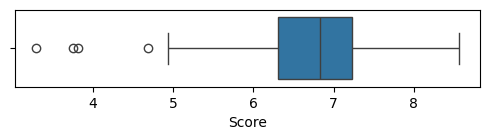

=================Mystery=================
Count: 318


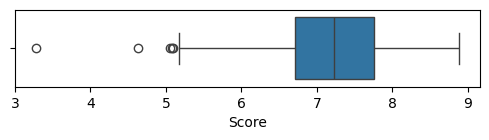

=================Romance=================
Count: 780


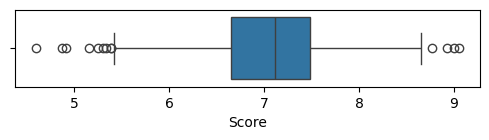

=================Sci-Fi=================
Count: 878


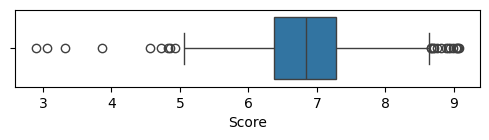

=================Slice of Life=================
Count: 449


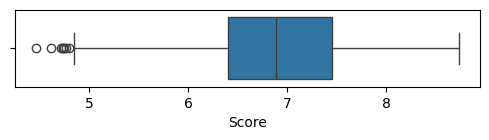

=================Sports=================
Count: 251


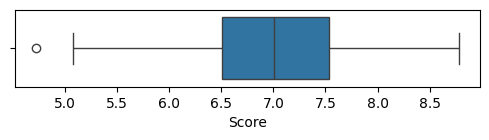

=================Supernatural=================
Count: 460


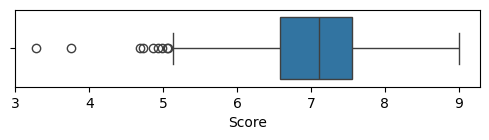

=================Suspense=================
Count: 75


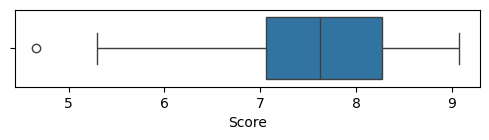

=================Ecchi=================
Count: 307


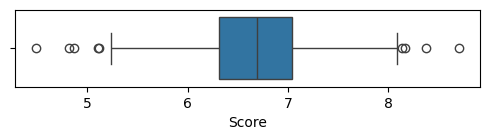

,Genre,Count,25,50,75
0,Action,1458,6.4200,6.960,7.4300
1,Adventure,995,6.4000,6.900,7.3600
2,Avant Garde,18,6.1550,6.615,7.2200
3,Award Winning,54,7.5150,7.895,8.3325
4,Boys Love,30,6.7225,7.020,7.4550
5,Comedy,1826,6.3700,6.880,7.3500
6,Drama,830,6.7300,7.205,7.6475
7,Fantasy,1091,6.4200,6.940,7.4150
8,Girls Love,43,6.5200,6.960,7.4250
9,Gourmet,57,6.4200,7.020,7.5300


In [49]:
# this will become the dataframe storing the genre stats
genre_stats = []

for genre in genres:
    print(f'================={genre}=================')
    df2 = df[df[genre]==True]
    stats = [genre]

    # get count
    count = len(df2.index)
    stats.append(count)
    
    # get quantiles
    quantiles = [0.25,0.5,0.75]
    for quantile in quantiles:
        stats.append(df2['Score'].quantile(quantile))

    print(f'Count: {count}')

    plt.figure(figsize=(6,1))
    sb.boxplot(data=df2['Score'],orient='h')
    plt.show()

    genre_stats.append(stats)
    
genre_stats = pd.DataFrame(genre_stats,columns=['Genre','Count','25','50','75'])
genre_stats

## Ordinary Least Squares
We use the genre data, as well as popularity. Using rank is cheating as it is based on score.

=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
Line Equation
        Score = [[-3.61990238e-02  2.00288027e-01 -1.69561614e-01  5.87972491e-01
  -1.76418842e-01  6.84972553e-02  2.25152507e-01 -8.91053821e-02
  -3.42596711e-01 -1.03061266e-01 -3.37076076e-01  6.21322599e-02
  -3.06752922e-02 -3.30965770e-02  5.24373201e-02  2.59143848e-01
   4.24216696e-02  1.52013412e-01 -4.52826596e-01 -1.16166866e-04]]*['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] + [7.3618832]
        
train dataset
        R^2: 0.3654444116831228
        MSE: 0.40785743141679687
        
test da

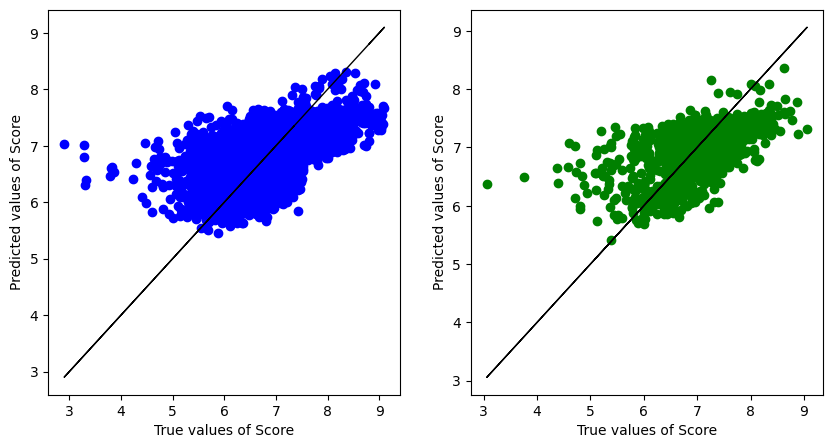

([0.3654444116831228, 0.34071234757324065],
 [0.40785743141679687, 0.42139488635795])

In [50]:
y = genres.copy()
y.append('Popularity')

linear_regression(x='Score',y=y,train_set=train_set, test_set=test_set)

# K Nearest Neighbours

In [51]:
def knn(x:str, y:str, train_set:object, test_set:object, k:int):
    """does K nearest Neighbour regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @param k: The number of neighbours
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    neighreg = KNeighborsRegressor(n_neighbors=k)
    # check if list
    if type(y) is list:
        neighreg.fit(train_set[y],train_set[[x]])
    else:
        neighreg.fit(train_set[[y]],train_set[[x]])


    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = neighreg.predict(datay)
        
        r2 = neighreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.3854529432013455
        MSE: 0.3949970478322949
        
test dataset
        R^2: 0.28208917543324197
        MSE: 0.45886488123946595
        


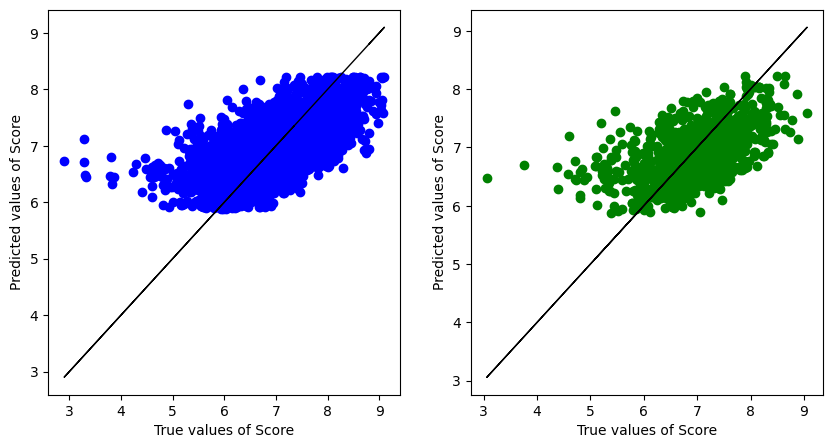

([0.3854529432013455, 0.28208917543324197],
 [0.3949970478322949, 0.45886488123946595])

In [52]:
y = genres.copy()
y.append('Popularity')

knn(x='Score',y=y,train_set=train_set, test_set=test_set, k=30)

# Decision Tree

In [61]:
def tree(x:str, y:str, train_set:object, test_set:object, max_depth:int=None):
    """does decision tree regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @param max_depth: maximum depth of tree
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    treereg = DecisionTreeRegressor(max_depth=max_depth)
    # check if list
    if type(y) is list:
        treereg.fit(train_set[y],train_set[[x]])
    else:
        treereg.fit(train_set[[y]],train_set[[x]])

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = treereg.predict(datay)
        
        r2 = treereg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

=== DEPTH = 3 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.37480675149241816
        MSE: 0.40183983431896214
        
test dataset
        R^2: 0.3089874060898299
        MSE: 0.44167242084825303
        


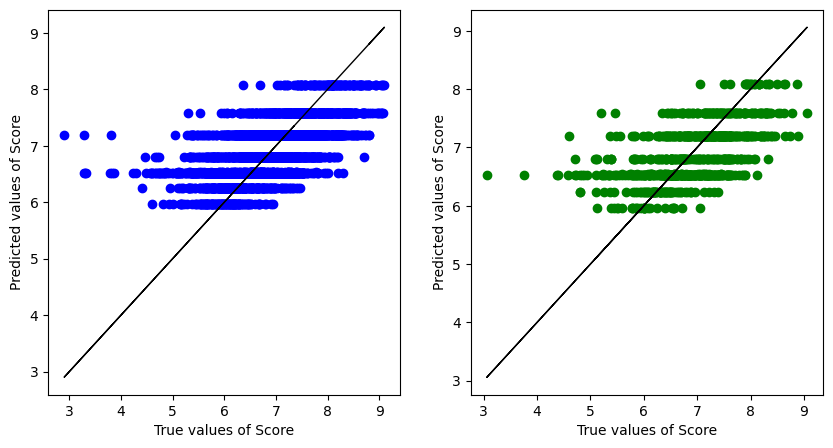

=== DEPTH = 4 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.4046681950445885
        MSE: 0.38264654079224286
        
test dataset
        R^2: 0.34356362615591807
        MSE: 0.4195724432864022
        


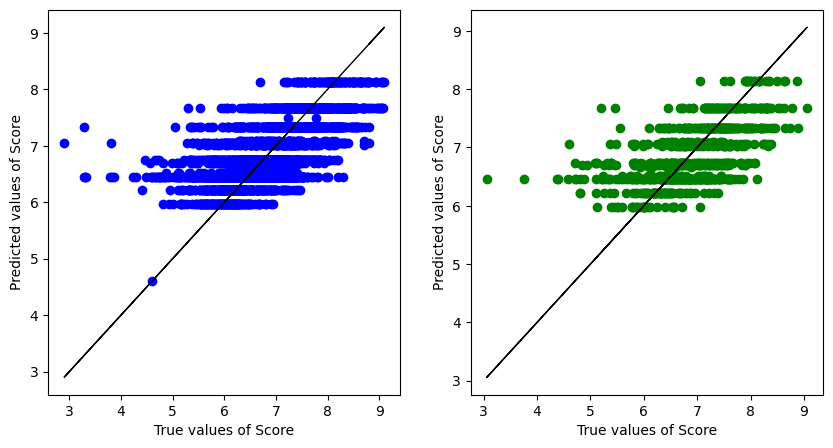

=== DEPTH = 5 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.4273166359499535
        MSE: 0.3680893686495173
        
test dataset
        R^2: 0.35250320827102266
        MSE: 0.41385855773793817
        


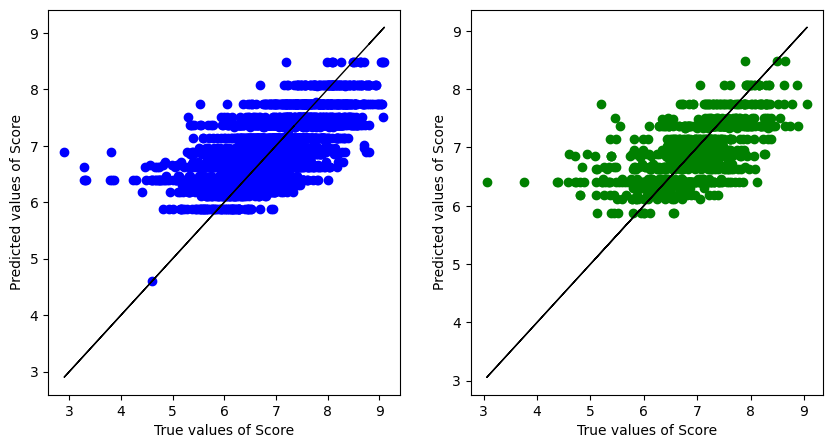

=== DEPTH = 6 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.4571010644486617
        MSE: 0.34894557616331173
        
test dataset
        R^2: 0.364497412448626
        MSE: 0.40619225868354064
        


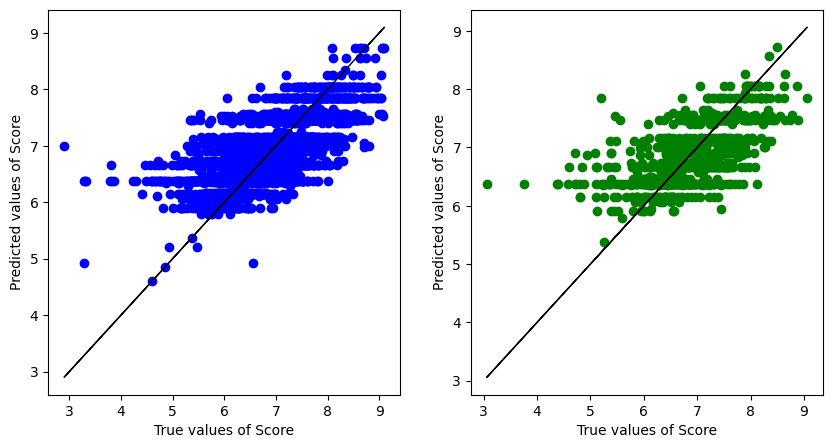

=== DEPTH = 7 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.4914123204923052
        MSE: 0.3268921879081345
        
test dataset
        R^2: 0.35269409886668457
        MSE: 0.4137365467756978
        


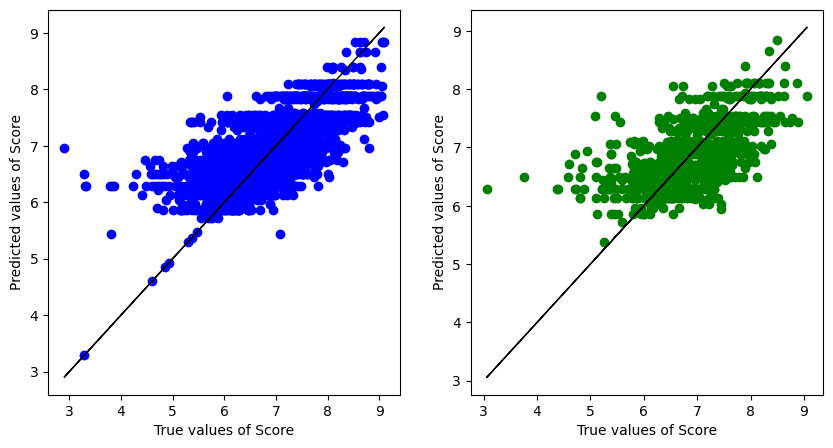

=== DEPTH = 8 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.5272454604392067
        MSE: 0.3038606163840276
        
test dataset
        R^2: 0.3064776524461106
        MSE: 0.44327657246187524
        


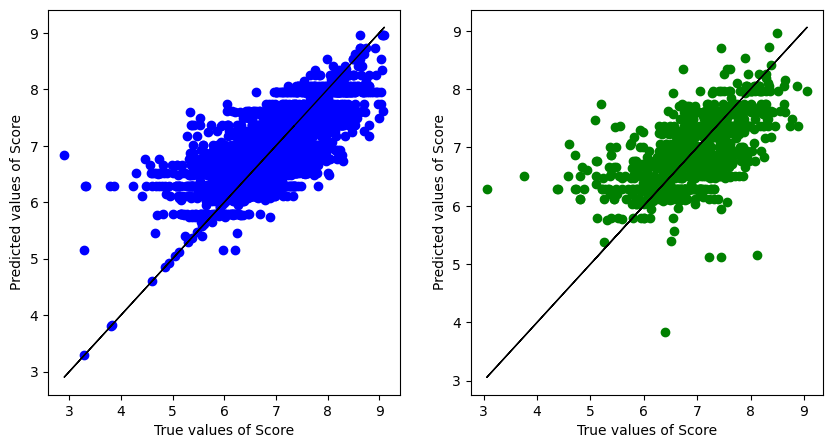

=== DEPTH = 9 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Popularity'] ===============
train dataset
        R^2: 0.5656265207670319
        MSE: 0.27919138177547076
        
test dataset
        R^2: 0.27211250415554744
        MSE: 0.4652416399180486
        


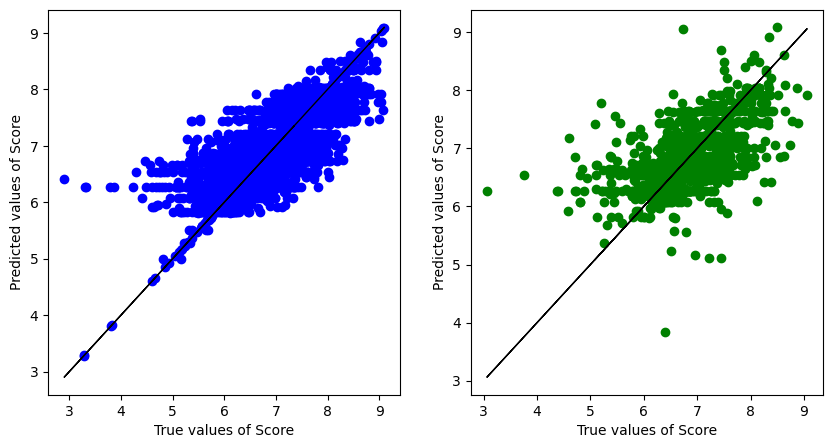

In [69]:
y = genres.copy()
y.append('Popularity')

for i in range (3,10):
    print(f'=== DEPTH = {i} ===')
    tree(x='Score',y=y,train_set=train_set, test_set=test_set, max_depth=i)